In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

import ipywidgets as widgets

TensorFlow 1.x selected.


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, frozen_graph):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    f = open(frozen_graph, "rb")
    graph_df = tf.GraphDef.FromString(f.read())

    if not os.path.isfile(frozen_graph) or graph_df is None:
      raise RuntimeError('Cannot find inference graph.')

    with self.graph.as_default():
      tf.import_graph_def(graph_df, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'UpperClothes', 'Dress', 'Coat',
    'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-Arm', 'Right-arm',
    'Left-leg', 'Right-leg', 'Left-shoe', 'Right-show'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [4]:
MODEL = DeepLabModel('/content/drive/MyDrive/TFM/model_19/frozen_inference_graph.pb')

In [20]:
image_list_siani = os.listdir('/content/drive/MyDrive/TFM/TGC_places/TGC_places/Arucas/')
image_picker_siani = widgets.Dropdown(options=image_list_siani, value=image_list_siani[0], disabled=False)
image_picker_siani

Dropdown(options=('284_Arucas_frame_01_44_40_000.jpg', '346_Arucas_frame_01_44_39_000.jpg', '344_Arucas_frame_…

running deeplab on image 27_Arucas_frame_01_31_38_000.jpg...


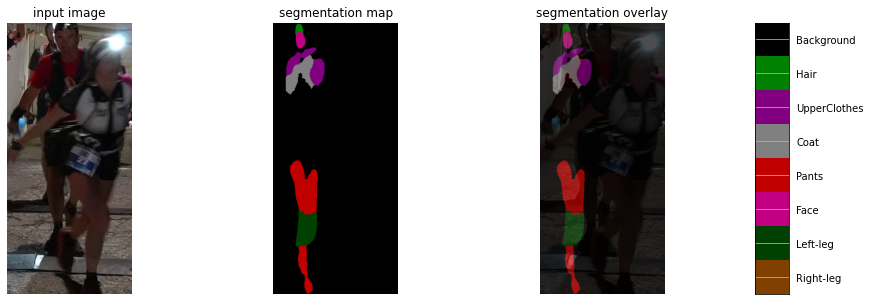

In [26]:
def run_visualization_siani(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/TGC_places/TGC_places/Arucas/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

run_visualization_siani(image_picker_siani.value)

In [13]:
image_list = os.listdir('/content/drive/MyDrive/TFM/lip_trainval_images/TrainVal_images/val_images/')
image_picker = widgets.Dropdown(options=image_list, value=image_list[0], disabled=False)
image_picker

Dropdown(options=('559665_189146.jpg', '566054_513371.jpg', '56002_443976.jpg', '561464_1188760.jpg', '564566_…

running deeplab on image 167006_466945.jpg...


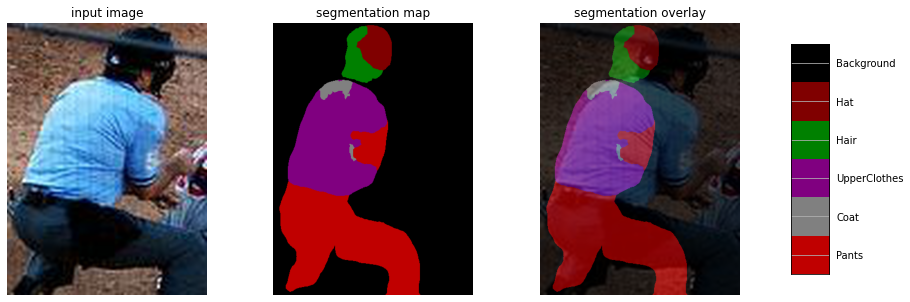

In [15]:
def run_visualization(file):
  """Inferences DeepLab model and visualizes result."""
  path = '/content/drive/MyDrive/TFM/lip_trainval_images/TrainVal_images/val_images/'
  try:
    original_im = Image.open(os.path.join(path, file))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + os.path.join(path, file))
    return

  print('running deeplab on image %s...' % file)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

run_visualization(image_picker.value)